Bootstrapping for covariance analyses

In [1]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import scipy.io as sio
import pingouin as pg
from copy import copy, deepcopy
from tqdm import tqdm

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import freezing_analysis as fa
from plotting import Fig, pretty_plot, FigMirror
from helpers import contiguous_regions
import covariance_analysis as cova
from stats_utils import resample, bootstrap_resample, get_bootstrap_prob, get_bootstrap_prob_paired
from subjects import save_df, load_df

bad/empty/missing SessionDirectories.csv file - must enter all directories manually
No SessionDirectories.pkl file found. Can't easily load files.


In [2]:
group_data_dir = "/home/nkinsky/Dropbox (University of Michigan)/Eraser/GroupData" if os.name == "posix" else "/Users/nkinsky/Documents/BU/Working/Eraser"
group_data_dir = Path(group_data_dir)

In [3]:
def add_memory_designations(df_use, key_use="d1_d2", before=['-2_-1', '-1_4'], during=['4_1'], 
                            after=['1_2', '2_7']):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    
    def create_bool_array_from_list(bool_list):
        bool_out = False
        for b in bool_list:
            bool_out = np.bitwise_or(bool_out, b)
            
        return bool_out
    
    before_bool_list = [df[key_use] == bef for bef in before]
    before_ind = np.where(create_bool_array_from_list(before_bool_list))[0]
    during_bool_list = [df[key_use] == dur for dur in during]
    during_ind = np.where(create_bool_array_from_list(during_bool_list))[0]
    after_bool_list = [df[key_use] == aft for aft in after]
    after_ind = np.where(create_bool_array_from_list(after_bool_list))[0]
    
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"

    df['Designation'] = desig
    
    return df

### Calculate covariance for all cells and for freeze cells, including any that go silent in later sessions 
(conservative, silent cells push down overall covariance)
Not tracked across days, could be different populations of cells on each day for these plots

In [ ]:
# Run through and tally covariance for all groups/neurons
bin_size = 0.5 # sec
all_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='all', keep_silent=True, buffer_sec=buffer_sec_plot)
freeze_silent_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='freeze_onset', keep_silent=True, buffer_sec=buffer_sec_plot)

In [ ]:
# Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
sigz_freeze_df, sigz_freeze_df_all = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True,
                                                         return_all_cov=True)
sigz_freeze_df = add_memory_designations(sigz_freeze_df)
save_df(sigz_freeze_df_all, "cov_sigz_freeze_df_all")

sigz_all_df, sigz_all_df_all = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True, return_all_cov=True)
sigz_all_df = add_memory_designations(sigz_all_df)
save_df(sigz_all_df_all, "cov_sigz_all_df_all")

# Break out into 3 groups instead of grouping Learners and Non-Learners together
sigz3way_freeze_df = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True, 
                                        group_ctrls=False)
sigz3way_freeze_df = add_memory_designations(sigz3way_freeze_df)

sigz3way_all_df = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True, group_ctrls=False)
sigz3way_all_df = add_memory_designations(sigz3way_all_df)


In [ ]:
# Sanity check - make sure mean of individual cells from _all_df matches mean pre-calculated in _df above
df_comp = sigz_freeze_df_all.groupby(["Group", "Mouse", "d1_d2"]).mean(numeric_only=True).reset_index()
df_comp["d1_d2"] = pd.Categorical(df_comp["d1_d2"], ["-2_-1", "-1_4", "4_1", "1_2", "2_7", "4_2"])
print(df_comp[df_comp.Mouse == "Marble07"].sort_values("d1_d2"))
print("")
print(sigz_freeze_df.head(6))

In [ ]:
# Same calculation for freeze cells but excluding peri-freeze times
freeze_silent_wo_frz_times = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                        neurons='freeze_onset', keep_silent=True, 
                                                        exclude_events='freeze_onset', exclude_buffer=(2, 2),
                                                        buffer_sec=buffer_sec_plot)

# Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
sigz_wo_frz_times_df, sigz_wo_frz_times_df_all = cova.cov_dict_to_df(freeze_silent_wo_frz_times, baseline_dict_use=all_cov, 
                                                                     include_silent=True, group_ctrls=False, return_all_cov=True)
sigz_wo_frz_times_df = add_memory_designations(sigz_wo_frz_times_df)
save_df(sigz_wo_frz_times_df_all, "cov_sigz_wo_frz_times_df_all")

In [ ]:
# Look at all cell covariance w/o freeze times included
all_cov_wofrzt = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                            neurons='all', keep_silent=True, exclude_events='freeze_onset',
                                            exclude_buffer=(2, 2), buffer_sec=buffer_sec_plot)

# Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
sigz_all_wo_frz_times_df, sigz_all_wo_frz_times_df_all = cova.cov_dict_to_df(all_cov_wofrzt, baseline_dict_use=all_cov, 
                                                                             include_silent=True, group_ctrls=False, return_all_cov=True)
sigz_all_wo_frz_times_df = add_memory_designations(sigz_all_wo_frz_times_df)
save_df(sigz_all_wo_frz_times_df_all, "cov_sigz_all_wo_frz_times_df")

### Bootstrap

#### Define function(s) for bootstrapping

In [4]:
def bootstrap_covariance(df, niter=10000, n_jobs=7, apply=lambda df2: df2.groupby("Group").mean(numeric_only=True).reset_index()):
    """Bootstrap each group during Before (Days -2 and -1), 4hr, and After (Days 1 and 2) epochs.  Only choose one day from each animal
    for the before and after epochs."""

    df_list = []
    for group_name in df.Group.unique():
        print(f"Bootstrapping for {group_name} group")
        for epoch in ["Before", "4hr", "After"]:
            if epoch == "Before":
                df_use = df[(df.Group == group_name) & ((df.d1_d2 == "-2_-1") | (df.d1_d2 == "-1_4"))]
            elif epoch == "4hr":
                df_use = df[(df.Group == group_name) & (df.d1_d2 == "4_1")]
            elif epoch == "After":
                df_use = df[(df.Group == group_name) & ((df.d1_d2 == "1_2") | (df.d1_d2 == "2_7"))]
            
            df_boot_temp = bootstrap_resample(df_use, niter, n_jobs=n_jobs, level=["Mouse", "d1_d2", "covz"], 
                                              n_level=[None, 1, None], apply=apply)
            df_boot_temp["Epoch"] = epoch
            
            df_list.append(df_boot_temp)
    
    df_boot_out = pd.concat(df_list, axis=0).reset_index()

    return df_boot_out

#### For all cells without freeze start times included

Bootstrapping for Learners group


100%|█████████████████████████████████████| 10000/10000 [05:57<00:00, 27.95it/s]


Bootstrapping for Non-learners group


100%|█████████████████████████████████████| 10000/10000 [17:51<00:00,  9.33it/s]


Bootstrapping for ANI group


100%|█████████████████████████████████████| 10000/10000 [13:35<00:00, 12.27it/s]


sigz_all_wo_frz_times_boot.csv saved


Text(0.5, 1.0, 'Re-load Check')

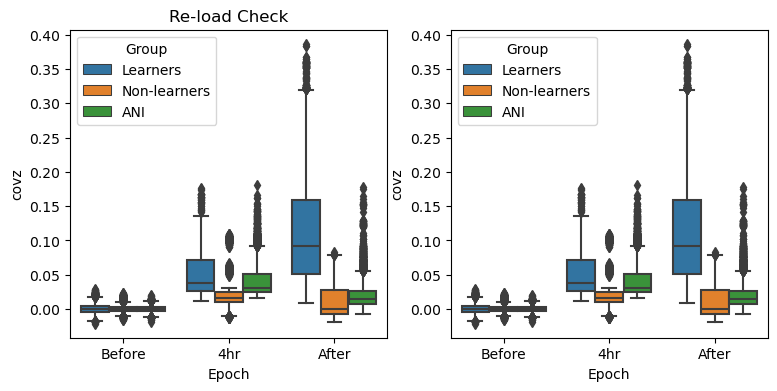

In [5]:
sigz_all_wo_frz_times_df_all = load_df("cov_sigz_all_wo_frz_times_df", save_dir=group_data_dir)
df_boot = bootstrap_covariance(sigz_all_wo_frz_times_df_all, niter=10000, n_jobs=12)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, "cov_sigz_all_wo_frz_times_boot", save_dir=group_data_dir)

# Replot
df_check = load_df("cov_sigz_all_wo_frz_times_boot", save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

#### For all cells with all times included

Bootstrapping for Learners group


100%|█████████████████████████████████████| 10000/10000 [05:52<00:00, 28.38it/s]


Bootstrapping for Non-learners group


100%|█████████████████████████████████████| 10000/10000 [17:49<00:00,  9.35it/s]


Bootstrapping for ANI group


100%|█████████████████████████████████████| 10000/10000 [13:24<00:00, 12.44it/s]


cov_sigz_boot_df_boot.csv saved


Text(0.5, 1.0, 'Re-load Check')

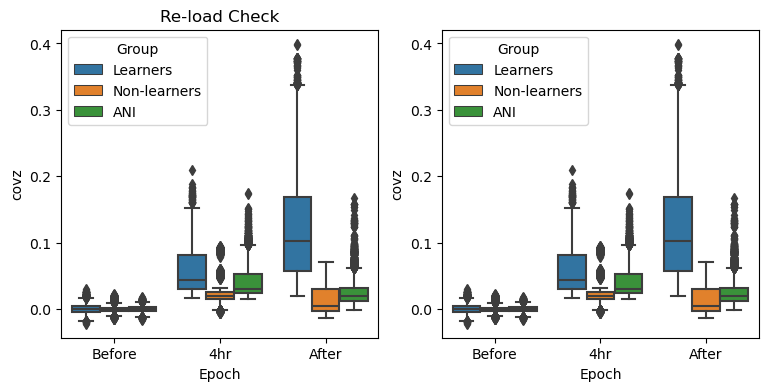

In [14]:
niter = 10000
n_jobs = 12
file_name = "cov_sigz_all_df_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

#### For Freeze cells with all times included

Bootstrapping for Learners group


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1047.22it/s]


Bootstrapping for Non-learners group


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 801.68it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:15<00:00, 656.58it/s]


cov_sigz_freeze_df_boot.csv saved


Text(0.5, 1.0, 'Re-load Check')

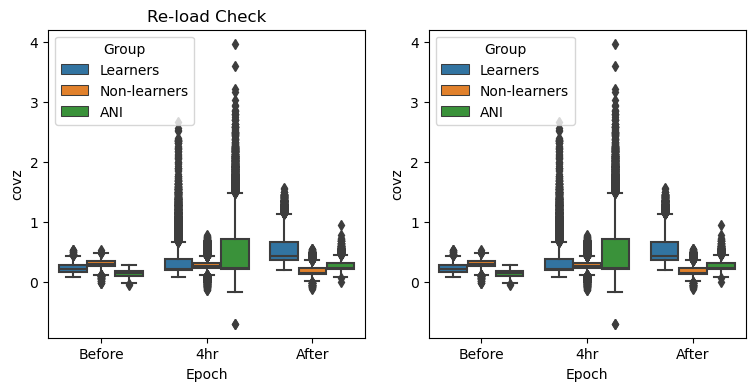

In [15]:
niter = 10000
n_jobs = 12
file_name = "cov_sigz_freeze_df_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

#### For Freeze cells with all times included

Bootstrapping for Learners group


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1036.91it/s]


Bootstrapping for Non-learners group


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 827.75it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:15<00:00, 640.37it/s]


cov_sigz_wo_frz_times_df_boot.csv saved


Text(0.5, 1.0, 'Re-load Check')

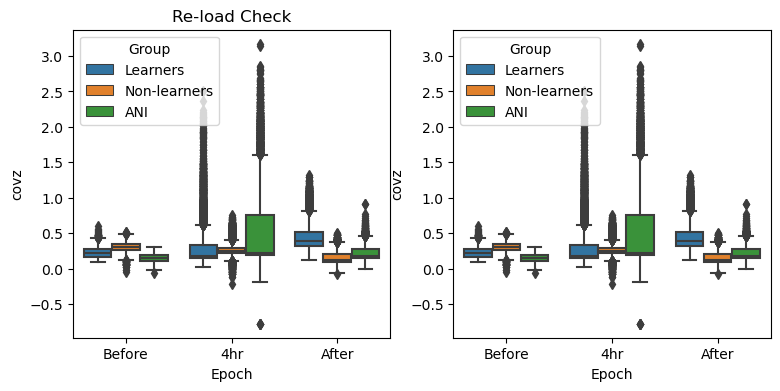

In [16]:
niter = 10000
n_jobs = 12
file_name = "cov_sigz_wo_frz_times_df_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

In [ ]:
save_df(df_boot, "sigz_all_wo_frz_times_boot")
df_check = load_df("sigz_all_wo_frz_times_boot")
_, ax = plt.subplots()
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax)

In [ ]:
df_check

In [ ]:
func = lambda df2: df2.groupby("Group").mean(numeric_only=True).reset_index()
df = sigz_all_wo_frz_times_df_all
n_iter = 10000

df_list = []
for group_name in df.Group.unique():
    print(f"Bootstrapping for {group_name} group")
    for epoch in ["Before", "4hr", "After"]:
        if epoch == "Before":
            df_use = df[(df.Group == group_name) & ((df.d1_d2 == "-2_-1") | (df.d1_d2 == "-1_4"))]
        elif epoch == "4hr":
            df_use = df[(df.Group == group_name) & (df.d1_d2 == "4_1")]
        elif epoch == "After":
            df_use = df[(df.Group == group_name) & ((df.d1_d2 == "1_2") | (df.d1_d2 == "2_7"))]
        
        df_boot_temp = bootstrap_resample(df_use, 100, n_jobs=7, level=["Mouse", "d1_d2", "covz"], n_level=[None, 1, None], apply=func)
        df_boot_temp["Epoch"] = epoch
        
        df_list.append(df_boot_temp)

df_boot = pd.concat(df_list, axis=0).reset_index()
df_boot